## IEA and IPCC data figures
Lindsey Gulden, 2026

Figures, analysis and data processing included in
[A critical assessment of the IPCC and IEA’s projections for carbon capture and storage](https://docs.google.com/document/d/1mwiSPu30LqLGQT-hkVah-VZzFI5dpKgsWUGA0rdgobI/edit?usp=sharing)


Note additional 'porcupine' figure versions are in the separate porcupine project folder


In [1]:
import re
import warnings
from pathlib import Path

import cpi
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import linregress

from utils.calcs import total_least_squares_regression
from utils.io import read_excel_sheets_to_dfs

cpi.update()

warnings.filterwarnings("ignore")

%load_ext jupyter_black

/Users/lindseygulden/dev/leg-up-private/.venv/lib/python3.11/site-packages/cpi/download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
/Users/lindseygulden/dev/leg-up-private/.venv/lib/python3.11/site-packages/cpi/download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
/Users/lindseygulden/dev/leg-up-private/.venv/lib/python3.11/site-packages/cpi/download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
/Users/lindseygulden/dev/leg-up-private/.venv/lib/python3.11/site-packages/cpi/download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(respon

## Data locations

In [2]:
PORCUPINE_DATA_DIR = "/Volumes/T5_external/data/porcupine"

AR6_DATA = Path(
    "/Volumes/T5_External/journal_submissions/emperor/data/AR6_Scenarios_Database_World_v1.1.csv"
)
AR6_METADATA = Path(
    "/Volumes/T5_External/journal_submissions/emperor/data/AR6_Scenarios_Database_metadata_indicators_v1.1.csv"
)

## Data and analysis for 'Porcupine' plot of IEA PV and CCS projections vs. reality

### Read IEA PV and CCS data

In [3]:
pv_actual_df = pd.read_excel(
    PORCUPINE_DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="pv_actual"
)
pv_proj_df = pd.read_excel(
    PORCUPINE_DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="pv_proj"
)
ccs_actual_df = pd.read_excel(
    PORCUPINE_DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="ccs_actual"
)
ccs_proj_df = pd.read_excel(
    PORCUPINE_DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="ccs_proj"
)

### Lightly process porcupine data

In [4]:
# append a year's actual CCS capacity and solar PV electricity generation to each projection.

# PV
actual_data_for_all_df = (
    pv_proj_df[
        [
            "prediction_year",
            "which_prediction",
            "class",
            "scenario",
            "exclude_from_plot",
            "notes",
        ]
    ]
    .groupby(["prediction_year", "which_prediction"])
    .first()
    .reset_index()
    .merge(pv_actual_df, left_on="prediction_year", right_on="year")
)
actual_data_for_all_df["notes"] = "actual data for year prediction was issued"
actual_data_for_all_df["exclude_from_plot"] = 0
pv_df = pd.concat([pv_proj_df, actual_data_for_all_df])

# variable for hue identificaiton (plotting)
pv_df["proj_uid"] = [
    str(x) + "." + str(y) for x, y in zip(pv_df.prediction_year, pv_df.which_prediction)
]

# CCS
actual_data_for_all_df = (
    ccs_proj_df[
        [
            "prediction_year",
            "which_prediction",
            "class",
            "scenario",
            "exclude_from_plot",
            "notes",
        ]
    ]
    .groupby(["prediction_year", "which_prediction"])
    .first()
    .reset_index()
    .merge(ccs_actual_df, left_on="prediction_year", right_on="year")
)
actual_data_for_all_df["notes"] = "actual data for year prediction was issued"
actual_data_for_all_df["exclude_from_plot"] = 0
ccs_df = pd.concat([ccs_proj_df, actual_data_for_all_df])

ccs_df["proj_uid"] = [
    str(x) + "." + str(y)
    for x, y in zip(ccs_df.prediction_year, ccs_df.which_prediction)
]
ccs_df.to_clipboard()

## Figure 1: 'Porcupine' plot comparing historical projections to true historical market growth (both CCS and PV)

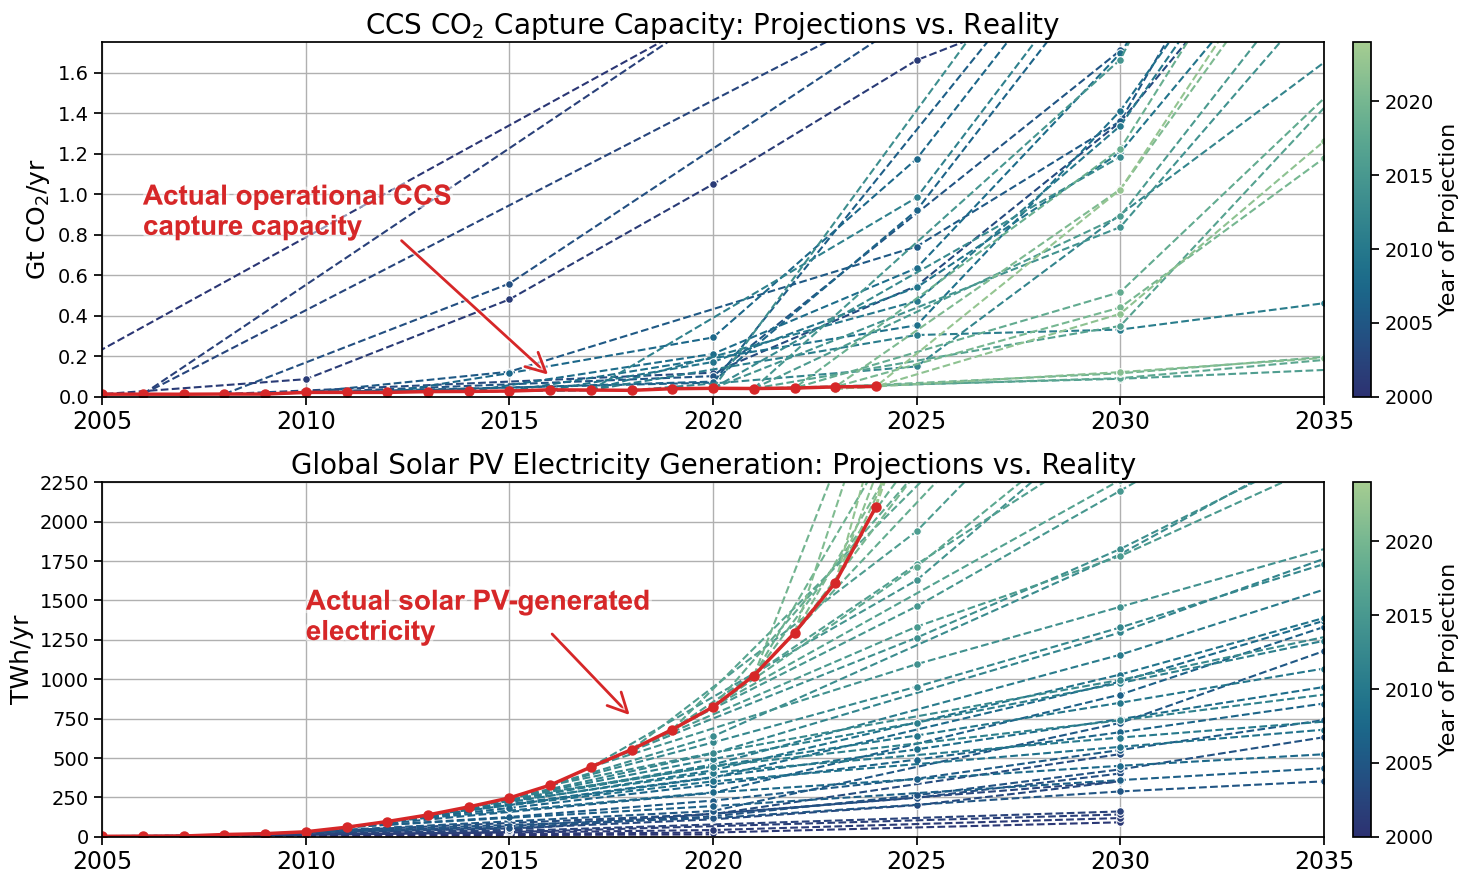

In [18]:
presentation_fig = False
# add Gtco2 for plotting
if presentation_fig:
    sns.set_context("talk")
    projection_lw = 2.5
    title_fontsize = 27
    actuallinewidth = 3.5
    actualmarkersize = 15
    actual_fontsize = 22
    ylabelsize = 20
    figure_height = 8
else:
    sns.set_context("notebook")
    projection_lw = 1.5
    title_fontsize = 20
    actuallinewidth = 2.5
    actualmarkersize = 13
    actual_fontsize = 20
    ylabelsize = 18
    figure_height = 9
# sns.set_context("notebook")

years = pv_actual_df["year"].values  # or Projection years used for coloring
norm = mc.Normalize(vmin=years.min(), vmax=years.max())
cmap = cm.get_cmap("crest_r")

# --- CCS CAPTURE CAPACITY ---
ccs_actual_df["gt_co2_per_yr"] = ccs_actual_df["mt_co2_per_yr"] / 1000
ccs_df["gt_co2_per_yr"] = ccs_df["mt_co2_per_yr"] / 1000
palette = "crest_r"  # "coolwarm"

marker = "."
font = "Arial"
weight = "semibold"
actualcolor = "tab:red"

startyear = 2005
endyear = 2035

markersize = 11


fig, axes = plt.subplots(2, 1, figsize=(16, figure_height))
# --- CCS
ax = axes[0]
sns.lineplot(
    data=ccs_df.loc[
        # (ccs_df["prediction_year"] != 2011) &
        (ccs_df["exclude_from_plot"] == 0)
    ],
    x="year",
    y="gt_co2_per_yr",
    hue="proj_uid",
    errorbar=None,
    palette=palette,
    linewidth=projection_lw,
    linestyle="--",
    marker=marker,
    markersize=markersize,
    ax=ax,
)
ax.set_xlim([startyear, endyear])
ax.set_ylim([0, 1.750])
ax.grid()
ax.plot(
    ccs_actual_df["year"],
    ccs_actual_df["gt_co2_per_yr"],
    color=actualcolor,
    marker=".",
    linewidth=actuallinewidth,
    markersize=actualmarkersize,
)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for matplotlib < 3.7

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Year of Projection", fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.tick_params(axis="x", which="major", labelsize=17)
ax.tick_params(axis="y", which="major", labelsize=14)
ax.set_ylabel("Gt " + r"${\mathrm{CO_2}}$" + "/yr", fontsize=ylabelsize)
ax.set_xlabel("")

# manually remove legend because it seems to REALLY want to plot
leg = ax.get_legend()
if leg is not None:
    leg.remove()

ax.text(
    x=2006,
    y=0.800,
    s="Actual operational CCS\ncapture capacity",
    fontsize=actual_fontsize,
    color=actualcolor,
    font=font,
    weight=weight,
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.5)],
)
ax.annotate(
    "",
    xytext=(2012.3, 0.78),
    xy=(2016, 0.1),
    arrowprops=dict(
        arrowstyle="->",
        linewidth=2,
        color=actualcolor,
        mutation_scale=35,
        path_effects=[
            pe.Stroke(linewidth=4, foreground="white", alpha=0.7),  # outline
            pe.Normal(),
        ],
    ),
)
ax.set_title(
    "CCS " + r"${\mathrm{CO_2}}$" + " Capture Capacity: Projections vs. Reality",
    fontsize=title_fontsize,
)


# --- SOLAR PV ---

ax = axes[1]
sns.lineplot(
    data=pv_df.loc[pv_df.exclude_from_plot == 0],
    x="year",
    y="world_solar_pv_twh",
    hue="proj_uid",
    errorbar=None,
    palette="crest_r",
    ax=ax,
    marker=".",
    linewidth=projection_lw,
    linestyle="--",
    markersize=markersize,
)
ax.set_xlim([startyear, endyear])
ax.set_ylim([0, 2250])
ax.grid()
ax.plot(
    pv_actual_df["year"],
    pv_actual_df["world_solar_pv_twh"],
    color=actualcolor,
    marker=".",
    linewidth=actuallinewidth,
    markersize=actualmarkersize,
)
ax.set_ylabel("TWh/yr", fontsize=ylabelsize)
ax.set_xlabel("")
ax.text(
    x=2010,
    y=1250,
    s="Actual solar PV-generated\nelectricity",
    fontsize=actual_fontsize,
    font=font,
    weight=weight,
    color=actualcolor,
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.5)],
)
ax.annotate(
    "",
    xytext=(2016, 1300),
    xy=(2018, 760),
    arrowprops=dict(
        arrowstyle="->",
        linewidth=2,
        color=actualcolor,
        mutation_scale=35,
        path_effects=[
            pe.Stroke(linewidth=4, foreground="white", alpha=0.7),  # outline
            pe.Normal(),
        ],
    ),
)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for matplotlib < 3.7

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Year of Projection", fontsize=16)
cbar.ax.tick_params(labelsize=14)

# manually remove legend because it seems to REALLY want to plot
leg = ax.get_legend()
if leg is not None:
    leg.remove()

ax.tick_params(axis="x", which="major", labelsize=17)
ax.tick_params(axis="y", which="major", labelsize=14)
ax.set_title(
    "Global Solar PV Electricity Generation: Projections vs. Reality",
    fontsize=title_fontsize,
)

fig.tight_layout()
fig.savefig("fig_1.png")
fig.savefig("fig_1.pdf")

## Data prep/processing/analysis for demonstrating the tradeoff between non-biomass renewables and CCS in AR6


### Read AR6 results (downloaded from IIASA scenario database)

In [29]:
# get metadata for the ar6 scenarios -- make a model-scenario column for merging

ar6_metadata_df = pd.read_csv(AR6_METADATA)
ar6_metadata_df.columns = [x.lower() for x in ar6_metadata_df.columns.values]
ar6_metadata_df["ms"] = [
    m + "-" + s for m, s in zip(ar6_metadata_df["model"], ar6_metadata_df["scenario"])
]
ar6_metadata_df.category_name.unique()

# get the ar6 scenario data, process lightly
ar6_df = pd.read_csv(AR6_DATA)
ar6_df.columns = [x.lower() for x in ar6_df.columns.values]
ar6_df["ms"] = [m + "-" + s for m, s in zip(ar6_df["model"], ar6_df["scenario"])]
ar6_df = ar6_metadata_df[["category_name", "ms"]].merge(ar6_df, on="ms")
ar6_df = ar6_df.loc[ar6_df.category_name != "failed-vetting"]

### Assemble lists of model-scenario pairs to plot

In [30]:
# add additional models (from IEA)
additional_models = [
    "IEA Energy Technology Perspectives Model 2020",
    # "IEA Energy Technology Perspective Model 2017",
    # "IEA World Energy Model 2017",
]
ar6_iea_ms = ar6_df.loc[ar6_df.model.isin(additional_models)].ms.unique()[0]

# Assemble list of models and scenarios for 'keep it below 1.5 C' for AR6
ar6_ms_1pt5C = sorted(
    list(
        ar6_df["ms"]
        .loc[
            ar6_df["category_name"].isin(
                [
                    "C1: limit warming to 1.5°C (>50%) with no or limited overshoot",
                    "C2: return warming to 1.5°C (>50%) after a high overshoot",
                ]
            )
        ]
        .unique()  # assuming 'Higher 1.5C high overshoot' in sr15 metadata is equivalent to C2
    )
) + [ar6_iea_ms]

print(
    f"There are {len(ar6_ms_1pt5C)} scenarios to plot for AR6 likely to stay at or below 1.5 degrees C"
)

There are 231 scenarios to plot for AR6 likely to stay at or below 1.5 degrees C


In [31]:
## get a working subset of data

ar6_subset_df = ar6_df[["ms", "model", "unit", "2050", "variable"]].loc[
    (ar6_df.ms.isin(ar6_ms_1pt5C))
    & (
        ar6_df.variable.isin(
            [
                "Primary Energy|Non-Biomass Renewables",
                "Primary Energy|Solar",
                "Primary Energy",
                "Secondary Energy|Electricity",
                "Secondary Energy|Electricity|Wind",
                "Secondary Energy|Electricity|Solar",
                "Secondary Energy|Electricity|Hydro",
                "Secondary Energy|Electricity|Non-Biomass Renewables",
                "Price|Carbon",
                "Carbon Sequestration|CCS",
                "Emissions|CO2|Energy and Industrial Processes",
            ]
        )
    )
]
ar6_subset_df = ar6_subset_df.pivot(
    index=["model", "ms"], columns="variable", values="2050"
).reset_index()

# compute a bunch of data...

# compute wind and solar percent using secondary energy
ar6_subset_df["ws_pct"] = [
    100 * ((s + w) / t)
    for s, w, t in zip(
        ar6_subset_df["Secondary Energy|Electricity|Solar"],
        ar6_subset_df["Secondary Energy|Electricity|Wind"],
        ar6_subset_df["Secondary Energy|Electricity"],
    )
]
# use non-biomass renewables to compute renewable percent
ar6_subset_df["renew_pct"] = [
    100 * (nbr - h) / t
    for nbr, h, t in zip(
        ar6_subset_df["Secondary Energy|Electricity|Non-Biomass Renewables"],
        ar6_subset_df["Secondary Energy|Electricity|Hydro"],
        ar6_subset_df["Secondary Energy|Electricity"],
    )
]
ar6_subset_df["ws_pct"].fillna(ar6_subset_df["renew_pct"], inplace=True)

# Adjust units (change from Mt to GtCO2)
ar6_subset_df["Carbon Sequestration|CCS"] = (
    ar6_subset_df["Carbon Sequestration|CCS"] / 1000
)
ar6_subset_df = ar6_subset_df.loc[ar6_subset_df.ws_pct <= 100]
ar6_subset_df["model_family"] = [
    re.split(
        r"[ -/_]", m.replace("ix", "").replace("COPPE", "COFFEE").replace("5.2", "")
    )[0]
    for m in ar6_subset_df["ms"]
]
# ar6_subset_df["Carbon Sequestration|CCS"] = [
#    x for x in ar6_subset_df["Carbon Sequestration|CCS"]
# ]
exclude_models = ["FARM 3.2"]
ar6_subset_df = ar6_subset_df.loc[~ar6_subset_df.model.isin(exclude_models)]

# add a TWh/yr column for the primary energy variables (which are in EJ/yr)
for v in [
    "Primary Energy|Non-Biomass Renewables",
    "Primary Energy|Solar",
    "Secondary Energy|Electricity|Solar",
    "Secondary Energy|Electricity|Non-Biomass Renewables",
]:
    ar6_subset_df[v + " TWh"] = ar6_subset_df[v] * 277.77777777778

### Group models into model families for plotting

In [32]:
expand_message = False
if expand_message:
    ar6_subset_df["model_family"] = [
        m if x == "MESSAGE" else x
        for m, x in zip(ar6_subset_df["model"], ar6_subset_df["model_family"])
    ]

model_families = sorted(
    [x for x in list(set(list(ar6_subset_df.model_family.unique()))) if x != "IEA"]
)

### Statistics to describe the AR6 ESM ensemble that keeps warming at or below 1.5

In [16]:
# Quantify the strength of the linear relationship between CCS and non-biomass renewables
pearsons_correlation_coefficient = ar6_subset_df["Carbon Sequestration|CCS"].corr(
    ar6_subset_df["Primary Energy|Non-Biomass Renewables"]
)
print(
    f"Pearson's correlation coefficient between non-biomass renewables and total CCS is {pearsons_correlation_coefficient:.3f}"
)
print("")

mean_renewable = (
    ar6_subset_df["Secondary Energy|Electricity|Non-Biomass Renewables TWh"]
    .loc[ar6_subset_df.model_family != "IEA"]
    .mean()
)
mean_ccs = (
    ar6_subset_df["Carbon Sequestration|CCS"]
    .loc[ar6_subset_df.model_family != "IEA"]
    .mean()
)
print(
    f"The mean renewable production in 2050 from the AR6 1.5 model scenarios is {mean_renewable} TWh/yr"
)
print(
    f"The mean CCS capacity in 2050 from the AR6 1.5 model scenarios is {mean_ccs} GtCO2/yr"
)
print("")

print(
    f"2050 mean projected CCS is a factor of ~{(9400 / 45):.0f} greater than current capacity (estimated at 45 MtCO2/yr)."
)
print(
    f"2050 mean projected PV is a factor of ~{(51901 / 9041):.0f} greater than current capacity (estimated at 9041 TWh/yr)."
)

Pearson's correlation coefficient between non-biomass renewables and total CCS is -0.480

The mean renewable production in 2050 from the AR6 1.5 model scenarios is 51901.00546907885 TWh/yr
The mean CCS capacity in 2050 from the AR6 1.5 model scenarios is 9.396647706220415 GtCO2/yr

2050 mean projected CCS is a factor of ~209 greater than current capacity (estimated at 45 MtCO2/yr).
2050 mean projected PV is a factor of ~6 greater than current capacity (estimated at 9041 TWh/yr).


### Total-least-squares/Demming regression for Renewables and CCS

In [33]:
# TLS/Demming regression for Renewables and CCS -- lets there be uncertainty in both the X and Y variables;
# finds best fit line that minimizes the orthogonal distance from points to the line. Thanks to Jevan for the suggestion

# find points for demming regression along the X axis (renewables)
x_tls_allrenew = np.linspace(
    min(ar6_subset_df["Secondary Energy|Electricity|Non-Biomass Renewables TWh"]),
    max(ar6_subset_df["Secondary Energy|Electricity|Non-Biomass Renewables TWh"]),
    100,
)

# find best fit line with demming regression (allows uncertainty in both X and Y direction -- finds best fit line by minimizing orthogonal distances)
b, M = total_least_squares_regression(
    ar6_subset_df["Secondary Energy|Electricity|Non-Biomass Renewables TWh"].values,
    ar6_subset_df["Carbon Sequestration|CCS"].values,
    intercept=True,
)

# use model to generate line for plotting
y_tls_allrenew_nolog = [M[0] * x + b for x in x_tls_allrenew]

225


### Figure 2: tradeoff between non-biomass renewables and CCS in AR6

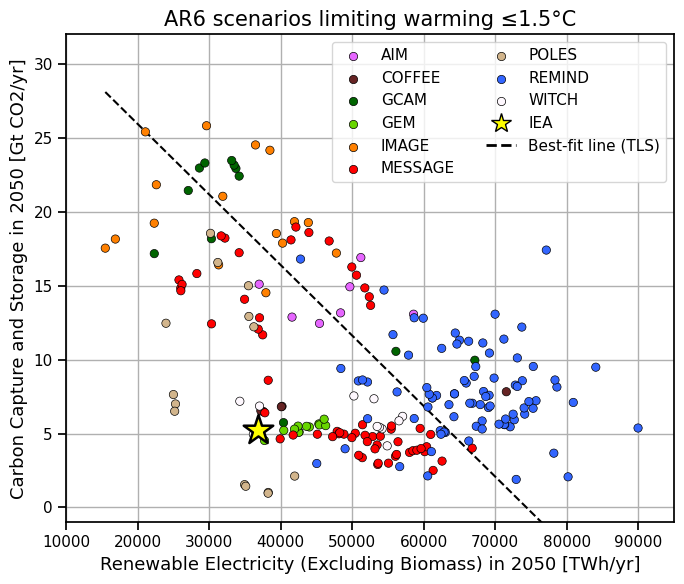

In [ ]:
# make a custom colormap
rainbow_colors = plt.cm.gist_ncar(np.linspace(0, 1, len(model_families)))

cmap = mc.ListedColormap(rainbow_colors)
color_dict = {mf: cmap(i) for i, mf in enumerate(model_families)} | {"IEA": "black"}
color_dict["COFFEE"] = (0.40, 0.14, 0.14, 1)
color_dict["REMIND"] = (0.20, 0.4, 1, 1)
color_dict["AIM"] = (0.9, 0.4, 1, 1)
# color_dict["COPPE"] = (0.537, 0.812, 0.941, 1)
color_dict["GCAM"] = (0, 0.392, 0, 1)
color_dict["MESSAGE"] = (1, 0, 0, 1)
color_dict["IMAGE"] = (1, 0.5, 0, 1)
color_dict["BET EMF33"] = (0.251, 0.878, 0.816, 1)
color_dict["MESSAGEix"] = (0.257, 0.412, 0.882, 1)
color_dict["TIAM"] = (0.5, 0.5, 0.5, 1)
color_dict["GRAPE"] = (0.502, 0, 0.502, 1)
color_dict["POLES"] = (0.824, 0.710, 0.549, 1)
# color_dict["IMACLIM"] = (0.9, 0.9, 0, 1)


fig, axes = plt.subplots(1, 1, figsize=(7, 6))
# AR6 -- PRIMARY ENERGY | ALL NON-BIOMASS RENEWABLES
sns.set_context("notebook")
ax = axes

sns.scatterplot(
    data=ar6_subset_df.loc[ar6_subset_df.model_family != "IEA"],
    x="Secondary Energy|Electricity|Non-Biomass Renewables TWh",
    y="Carbon Sequestration|CCS",
    hue="model_family",
    palette=color_dict,
    edgecolor="k",
    zorder=6,
)
sns.scatterplot(
    data=ar6_subset_df.loc[ar6_subset_df.model_family == "IEA"],
    x="Secondary Energy|Electricity|Non-Biomass Renewables TWh",
    y="Carbon Sequestration|CCS",
    color="yellow",
    s=500,
    ax=ax,
    marker="*",
    edgecolor="black",
    zorder=8,
)

# Fix the legend
handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_edgecolor("k")
    handle.set_linewidth(0.5)
plt.plot(
    x_tls_allrenew,
    y_tls_allrenew_nolog,
    ls="--",
    color="black",
    label="TLS regression no log transformation",
)
# Add IEA star marker
star_handle = Line2D(
    [],
    [],
    marker="*",
    color="w",
    label="IEA",
    markerfacecolor="yellow",
    markeredgecolor="black",
    markersize=15,
)
handles.append(star_handle)
labels.append("IEA")

reg_line_handle = plt.Line2D([], [], ls="--", color="black", lw=2)
handles.append(reg_line_handle)
labels.append("Best-fit line (TLS)")

ax.set_title(
    "AR6 scenarios limiting warming " + "\u2264" + "1.5" + "\u00B0" + "C", fontsize=15
)
ax.set_xlabel("Renewable Electricity (Excluding Biomass) in 2050 [TWh/yr]", fontsize=13)
# Update the legends
ax.legend(handles, labels, ncol=2, fontsize=11)
ax.grid("both", zorder=-1)
ax.tick_params(axis="both", labelsize=11)
ax.set_ylabel("Carbon Capture and Storage in 2050 [Gt CO2/yr]", fontsize=13)
ax.set_ylim([-1, 32])

ax.set_xlim([10000, 95000])
fig.tight_layout()
fig.savefig("fig_2.png")
fig.savefig("fig_2.pdf")

## IEA Carbon-price forcing -- how has assumed CO2 price changed throughout the years?

### Details/figures regarding carbon-price forcing function used by IEA/IEA's assumed CO2 price scenarios through time

In [35]:
# read in the data!
co2_df = pd.read_csv(PORCUPINE_DATA_DIR / Path("weo_co2_price.csv"))
# Convert dollars to 2024 USD
price_year = 2024
co2_df["usd_2024"] = [
    cpi.inflate(d, int(y), to=int(price_year))
    for d, y in zip(co2_df.usd_per_tco2, co2_df.usd_year)
]

# Compute distance out into the future from agiven projection year (the 'year out' into the future)
co2_df["year_out"] = [y - py for y, py in zip(co2_df.year, co2_df.prediction_year)]

### Compute the real-world weighted average global carbon price for plotting below

In [ ]:
retval = read_excel_sheets_to_dfs(
    PORCUPINE_DATA_DIR / Path("world_bank_carbon_price_info.xlsx"),
    ["Compliance_Emissions", "Compliance_Price"],
)

emis_df = retval["Compliance_Emissions"]
emis_df.columns = emis_df.iloc[1, :]
emis_df.columns = [int(x) if isinstance(x, float) else x for x in emis_df.columns]
emis_df = emis_df.loc[2:, :]
emis_df.set_index("Name of the initiative", inplace=True)

price_df = retval["Compliance_Price"]
price_df.columns = price_df.iloc[0, :]
price_df.columns = [int(x) if isinstance(x, float) else x for x in price_df.columns]
price_df = price_df.loc[1:, :]
price_df.set_index("Name of the initiative", inplace=True)

# identify the year columns
year_cols = list(range(1990, 2026, 1))

# find the weighted price
weight_price_df = price_df.copy()
for y in year_cols[:-1]:
    weight_price_df[y] = cpi.inflate(emis_df[y] * price_df[y], int(y), int(2024))

# group by the region
region_price_df = price_df[["Region"] + year_cols].groupby("Region").mean()

### Figure S2:  Mean of CO2 pricing cases used by IEA, separated by projection year.

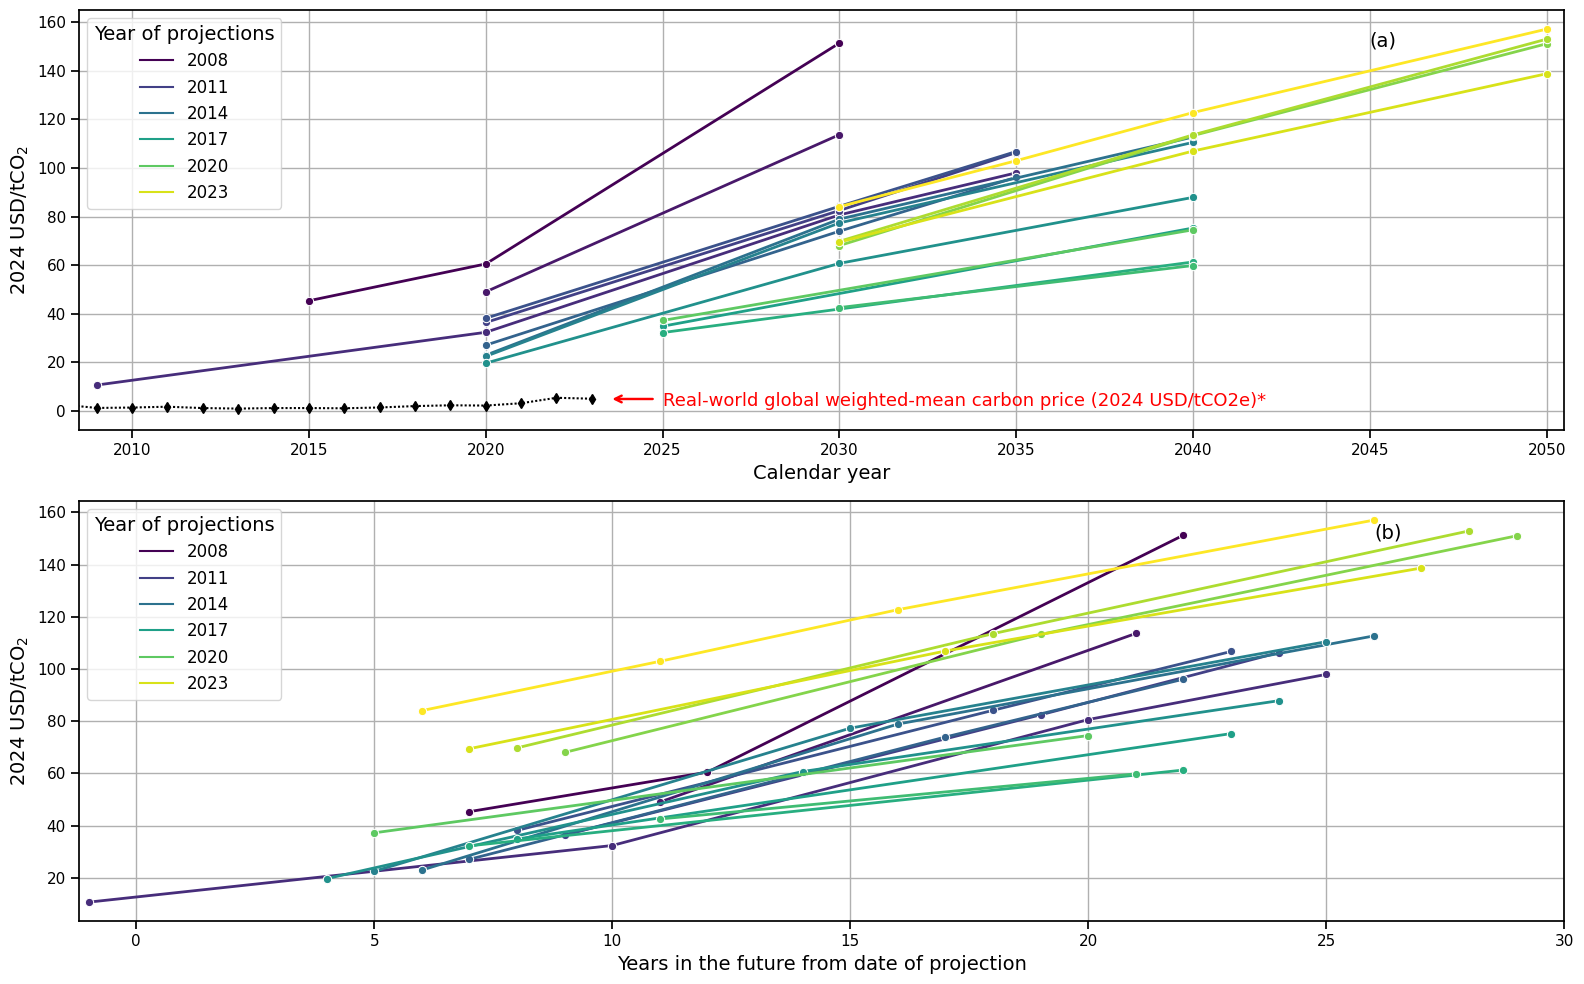

In [29]:
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (5, 10))]

estimator = "mean"
palette = "viridis"  # "crest_r"  # "coolwarm"

marker = "."
font = "Arial Narrow"
weight = "semibold"
actualmarkersize = 14
actual_fontsize = 20
legend_titlesize = 14
legend_fontsize = 12
actuallinewidth = 4
ylabelsize = 14
xlabelsize = 14
projection_lw = 2.0
markersize = 12

title_fontsize = 24
vars = ["year", "year_out"]
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
for i, ax in enumerate(axes.reshape(-1)):
    sns.lineplot(
        co2_df,
        x=vars[i],
        y="usd_2024",
        hue="prediction_year",
        errorbar=None,
        # errorbar=("ci", 95),
        # err_style="bars",
        palette=palette,
        linewidth=projection_lw,
        marker=marker,
        markersize=markersize,
        estimator=estimator,
        ax=ax,
    )
    ax.grid()
    ax.legend(
        title="Year of projections",
        fontsize=legend_fontsize,
        title_fontsize=legend_titlesize,
    )
    ax.set_ylabel("2024 USD/tCO$_2$", fontsize=ylabelsize)


axes[0].set_xlim([2008.5, 2050.5])
axes[1].set_xlim([-1.2, 30])
axes[0].set_xlabel("Calendar year", fontsize=xlabelsize)
axes[1].set_xlabel("Years in the future from date of projection", fontsize=xlabelsize)

linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (5, 10))]

plt.subplot(2, 1, 1)
plt.plot(
    weight_price_df.sum()[year_cols[:-2]],
    color="k",
    linestyle=(0, (1, 1, 1, 1)),
    marker="d",
    markersize=5,
    lw=1.5,
)
axes[0].annotate(
    "",
    xytext=(2024.8, 5),
    xy=(2023.5, 5),
    arrowprops=dict(arrowstyle="->", lw=1.75, color="r"),
    color="r",
)
axes[0].text(
    2025,
    2,
    "Real-world global weighted-mean carbon price (2024 USD/tCO2e)*",
    fontsize=13,
    color="r",
)
axes[0].text(2045, 150, "(a)", fontsize=14)
axes[1].text(26, 150, "(b)", fontsize=14)

fig.tight_layout()
fig.savefig("fig_s2.pdf")
fig.savefig("fig_s2.png")

### EPPA Morris et al., 2019 Calculations
Data taken from Table 1 and Table 2 on p. 173 from Morris et al., 2019 (https://doi.org/10.1016/j.ijggc.2019.05.016)

In [36]:
# markup_over_base_electric_price
gas_markup = 0.89
coal_markup = 1.03
gas_with_ccs_markup = 1.24
coal_with_ccs_markup = 1.66
solar_markup = 1.89
gas_with_advanced_ccs_markup = 0.97

print(
    f"In EPPA, CCS added onto a gas-fired power plant is assumed to add {100*((gas_with_ccs_markup / gas_markup)-1):.1f}% to the price per MWh"
)
print(
    f"In EPPA, CCS added onto a coal-fired power plant is assumed to add {100*((coal_with_ccs_markup / coal_markup)-1):.1f}% to the price per MWh"
)
print(
    f"In EPPA, Solar PV electricity is {100*((solar_markup)-1):.1f}% more expensive than 'base electricity' prices"
)

In EPPA, CCS added onto a gas-fired power plant is assumed to add 39.3% to the price per MWh
In EPPA, CCS added onto a coal-fired power plant is assumed to add 61.2% to the price per MWh
In EPPA, Solar PV electricity is 89.0% more expensive than 'base electricity' prices


## Find best-fit lines for global PV growth (to help compute the rate of growth of the industry over various periods)

In [37]:
# make a year for fitting lies

pv_actual_df["adjust_year"] = pv_actual_df["year"] - 2000
np.polyfit(pv_actual_df["adjust_year"], np.log(pv_actual_df["world_solar_pv_twh"]), 1)

# fit lines
start_idx = 0
for time_chunk in [12, 24]:
    x = list(pv_actual_df["adjust_year"][start_idx:time_chunk])
    y = list(pv_actual_df["world_solar_pv_twh"][start_idx:time_chunk])

    # find natural log of y (must be > 0)
    logy = np.log(y)

    # do linear regression on the log values: ln(y) = m * x + b
    slope, intercept, r_value, p_value, slope_std_err = linregress(x, logy)

    print(f"Best-fit line in log space for chunk {start_idx} to {time_chunk}:")
    print(f"ln(y) = {slope:.6f} * x + {intercept:.6f}")
    print(f"R² = {r_value**2:.6f}")

    # convert back to exponential parameters
    b = slope
    a = np.exp(intercept)

    print("\nEquivalent exponential model:")
    print(f"y = {a:.6f} * exp({b:.6f} * x)")

    pv_actual_df[f"fit_{time_chunk}"] = [
        a * np.exp(b * x) for x in list(pv_actual_df["adjust_year"])
    ]
    print("\nDoubling time for this model is:")
    dt = np.log(2) / b
    print(f"{dt:0.3} yrs")
    start_idx = time_chunk

Best-fit line in log space for chunk 0 to 12:
ln(y) = 0.424898 * x + -0.770050
R² = 0.968419

Equivalent exponential model:
y = 0.462990 * exp(0.424898 * x)

Doubling time for this model is:
1.63 yrs
Best-fit line in log space for chunk 12 to 24:
ln(y) = 0.233617 * x + 2.045607
R² = 0.996632

Equivalent exponential model:
y = 7.733849 * exp(0.233617 * x)

Doubling time for this model is:
2.97 yrs


In [38]:
# compute fited outputs
pv_actual_df["fitted"] = [
    0.776074 * np.exp(0.354337 * x) for x in list(pv_actual_df["adjust_year"])
]
pv_actual_df["logx"] = [np.log(x) for x in pv_actual_df["world_solar_pv_twh"]]
pv_actual_df["logx12"] = [np.log(x) for x in pv_actual_df["fit_12"]]
pv_actual_df["logx24"] = [np.log(x) for x in pv_actual_df["fit_24"]]

### Fig S1: shows rates of growth of PV industry 

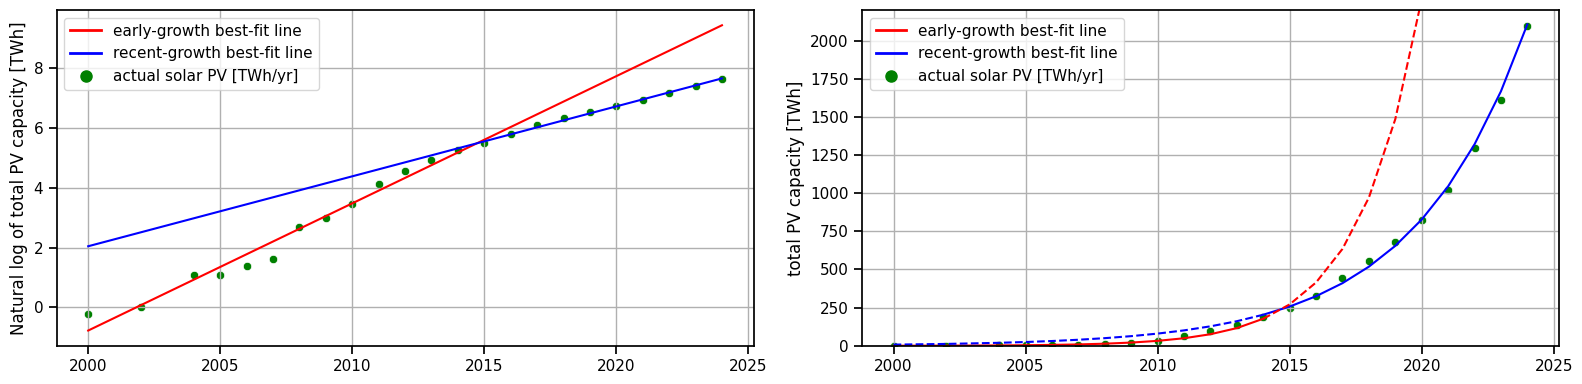

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ax = axes[0]
sns.lineplot(data=pv_actual_df, x="year", y="logx12", color="r", ax=ax)
sns.lineplot(data=pv_actual_df, x="year", y="logx24", color="b", ax=ax)
sns.scatterplot(data=pv_actual_df, x="year", y="logx", color="g", ax=ax)
ax.set_ylabel("Natural log of total PV capacity [TWh]")
ax = axes[1]

sns.lineplot(data=pv_actual_df.loc[0:12], x="year", y="fit_12", color="r", ax=ax)
sns.lineplot(data=pv_actual_df.loc[12:], x="year", y="fit_24", color="b", ax=ax)
sns.lineplot(
    data=pv_actual_df.loc[12:], x="year", y="fit_12", color="r", ax=ax, linestyle="--"
)
sns.lineplot(
    data=pv_actual_df.loc[0:12], x="year", y="fit_24", color="b", ax=ax, linestyle="--"
)
sns.scatterplot(data=pv_actual_df, x="year", y="world_solar_pv_twh", color="g", ax=ax)
ax.set_ylabel("total PV capacity [TWh]")

# Legend (for both subplots)
legend_elements = [
    Line2D([0], [0], color="red", linewidth=2, label="early-growth best-fit line"),
    Line2D([0], [0], color="blue", linewidth=2, label="recent-growth best-fit line"),
    Line2D(
        [0],
        [0],
        color="green",
        marker="o",
        linestyle="None",
        markersize=8,
        label="actual solar PV [TWh/yr]",
    ),
]
ax.set_ylim([0, 2200])

for i in range(2):
    axes[i].grid("both")
    axes[i].set_xlabel("")
    axes[i].legend()
    axes[i].legend(handles=legend_elements, loc="best")
fig.tight_layout()
fig.savefig("fig_s1.pdf")
fig.savefig("fig_s1.png")